In [1]:
%matplotlib inline
from pylab import *

from Orbit_Simulator import Orbit_Simulator

#HIP = 16537 #epsilon Eridani, dropped due to high zodi
HIP = 8102   #tau Ceti
#HIP = 37279  #Procyon A
#HIP = 108870 #epsilon Indi A
#HIP = 32349  #Sirius A
#HIP = 19849  #omicron 2 Eridani
#HIP = 97649  #Altair
#HIP = 99240  #delta Pavonis
#HIP = 15510  #82 Eridani
#HIP = 96100  #sigma Draconis
#HIP = 2021  #beta Hyi
#HIP = 61317  #beta CVn
#HIP = 22449  #1 Ori
##HIP = 91262 #Vega, dropped due to high zodi
##HIP = 86974 #Mu Herculis, dropped to binary companion contamination
#HIP = 113368 #Fomalhaut
#HIP = 17378  #Delta Eridani
#HIP = 27072  #Gamma Leporis
#HIP = 1599   #Zeta Tucanae
    
OrbSim = Orbit_Simulator(HIP)


Initializing Orbit_Simulator
tau Ceti


Time Windows (4):  [[15, 47], [148, 183], [381, 413], [514, 548]]
Window Durations (days):  [32, 35, 32, 34]
Observation Times:  [ 15 148 381 514]


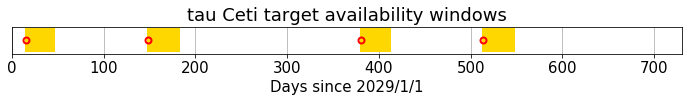

In [2]:
'''
Plot the target availability windows
'''
OrbSim.get_observation_time_array(init_date = '2029/1/1',
                                  duration_yrs=2)

figure(1, figsize=(12,0.5))
col='k'
plot(OrbSim.days[OrbSim.obs_cut], np.ones(len(OrbSim.days[OrbSim.obs_cut])), 
     '|', mew=2, ms=24, color='gold')
xlabel('Days since %s'%OrbSim.init_date)
xlim(0,len(OrbSim.ang))
yticks([])
grid(True)
title(OrbSim.star_name+ ' target availability windows')

plot(OrbSim.t_obs_array, 1.*np.ones(len(OrbSim.t_obs_array)), 
     'ro', ms=6, mfc='none', mec='r', mew=2)


In [3]:
hits = 0
while hits<3:
    OrbSim.sample_orbits(num_samples=1)
    entry = np.random.randint(len(OrbSim.Period))
    hits = OrbSim.hits[entry]
print('entry:', entry)
print('Number of Detections', OrbSim.hits[entry])
true_dat   = np.array([OrbSim.projected_x_mas[:,entry], OrbSim.projected_y_mas[:,entry]])
SNR        = OrbSim.SNR[:, entry]

# Generate simulated astrometric data with uncertainties
err_data   = np.array([65./SNR,65./SNR]) 
dat        = true_dat + np.random.normal(0.,err_data)
data = np.zeros((2,(OrbSim.hits[entry])))
data_uncertainties= np.zeros((2,(OrbSim.hits[entry])))
time = np.zeros((OrbSim.hits[entry]))

print('SNR',SNR)
print('astrometric uncertainty',65./SNR)
count=0
for ii in range(0,len(SNR)):
    if SNR[ii]>OrbSim.SNR_cut:
        data[:,count] = dat[:,ii]
        data_uncertainties[:,count] = err_data[:,ii]
        time[count] = OrbSim.t_obs_array[ii]
        count+=1

entry: 0
Number of Detections 3
SNR [ 8.11667725 35.68523296  2.12788759 34.2805383 ]
astrometric uncertainty [ 8.00820311  1.82148173 30.54672645  1.89611958]


In [ ]:
from Kepler import Kepler
KPC = Kepler(force_new_LUT=False)

truth_parameters = np.array([OrbSim.a_SM, 
                             OrbSim.t_0, 
                             OrbSim.star_model.Mass, 
                             OrbSim.eccentricity, 
                             OrbSim.LAN, 
                             OrbSim.inclination, 
                             OrbSim.arg_peri, 
                             OrbSim.star_model.d_pc])

truth_Kepler_parameters = np.array([OrbSim.a_SM[entry], 
                                    OrbSim.t_0[entry], 
                                    OrbSim.Period[entry], 
                                    OrbSim.eccentricity[entry], 
                                    OrbSim.LAN[entry], 
                                    OrbSim.inclination[entry], 
                                    OrbSim.arg_peri[entry]])


'''
Plot data
'''
rcParams['font.size']=16
figure(1, figsize=(4.5,4))
ax=subplot(111)
dt = OrbSim.Period/2000.
t_val = np.arange(0.,2.*OrbSim.Period, dt)

''' 
Plot the true orbit on the sky 
'''
pts_s = KPC.get_Orbit_points(t_val, *truth_Kepler_parameters)
plot(pts_s[0], pts_s[1], '-', color='dodgerblue')

''' 
Plot the inner and outer habitable zone bounds 
projected on the sky 
'''
prm = truth_Kepler_parameters.copy()
prm[0] = OrbSim.HZ_mas[0]
prm[-2] = 0.
pts_In = KPC.get_Orbit_points(t_val, *prm)
plot(pts_In[0], pts_In[1], 'g-', alpha=0.25)
prm[0] = OrbSim.HZ_mas[1]
pts_Out = KPC.get_Orbit_points(t_val, *prm)
plot(pts_Out[0], pts_Out[1], 'g-', alpha=0.25)

'''
Get bounds for plotting
'''
abs_max = np.max([np.max(np.abs(pts_s[0])), 
                  np.max(np.abs(pts_s[1])),
                  np.max(np.abs(pts_Out[0])),
                  np.max(np.abs(pts_Out[1]))])


'''
Plot true planet positions during observation times
'''
pts_0 = KPC.get_Orbit_points(OrbSim.t_obs_array, *truth_Kepler_parameters)
plot(pts_0[0], pts_0[1], 'o', mfc='none', mec='dodgerblue', ms=12)

'''
Label the observation number
'''
for k in range(len(OrbSim.t_obs_array)):
    text(pts_0[0,k], pts_0[1,k], ' %d'%(k+1), verticalalignment='top', color='blue')

'''
Plot the simulated data with error bars
'''
errorbar(data[0], data[1], xerr = 3.*data_uncertainties[0], yerr=3.*data_uncertainties[1], fmt='r.')

'''
Mark the position of the star
'''
plot([0.], [0.], '*', ms=12, color='orange')

# print 'data[0]', data[0]
# print 'data[1]', data[1]
# print 'time_array', time_array

'''
Draw the size of the inner working angle
'''
circle1 = plt.Circle((0., 0.), 100., color='k', alpha=0.2)
ax.add_artist(circle1)
text(0., -30., 'IWA', color='k', verticalalignment='top', horizontalalignment='center')
#xlim(-fl['HZ_mas'][1], fl['HZ_mas'][1])
#ylim(-fl['HZ_mas'][1], fl['HZ_mas'][1])
text(-abs_max, abs_max, 'HZ bounds', color='g', verticalalignment='top')
abs_max *= 1.1
xlim(-abs_max, abs_max)
ylim(-abs_max, abs_max)

xlabel('$\delta$RA, mas')
ylabel('$\delta$dec, mas')
tight_layout()
axes().set_aspect('equal', 'datalim')
''' 
savefig('orbit_example_1.pdf')
'''
